<a href="https://colab.research.google.com/github/mayank5695/Exploring_RNNs/blob/master/Auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow_privacy


After training using CNN for MNIST, we are trying an approach to use autoencoder to train the data and apply privacy.

Here, we will also give the privacy budget for training and stop the training if we exceed the privacy budget. We will check the privacy budget used after every epoch.


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf

import numpy as np

tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Dropout, Add, Multiply,Conv2D,Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback

from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamOptimizer, DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.dp_query.gaussian_query import GaussianAverageQuery
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


In [0]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.


(28, 28, 1)

In [0]:
def build_model():
  encoder=Sequential()
  encoder.add(tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
  encoder.add(tf.keras.layers.MaxPool2D((2,2),padding='same'))
  encoder.add(tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'))
  encoder.add(tf.keras.layers.MaxPool2D((2,2),padding='same'))
  encoder.add(tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'))
  #decoder
  encoder.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  encoder.add(tf.keras.layers.UpSampling2D((2, 2)))
  encoder.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  encoder.add(tf.keras.layers.UpSampling2D((2, 2)))
  encoder.add(tf.keras.layers.Conv2D(1, (3, 3), activation='relu',padding='same'))
  
  

  return encoder

autoencoder=build_model()
autoencoder.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 14, 14, 8)        

In [0]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])
auto_history=autoencoder.fit(train_data,train_data,batch_size=256,epochs=15,validation_data=(test_data,test_data),verbose=1)


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.0922 - acc: 0.8142 - val_loss: 0.0859 - val_acc: 0.8140
Epoch 2/15
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.1024 - acc: 0.8131 - val_loss: 0.1236 - val_acc: 0.8137
Epoch 3/15
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.1170 - acc: 0.8088 - val_loss: 0.1080 - val_acc: 0.8095
Epoch 4/15
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.1057 - acc: 0.8122 - val_loss: 0.1390 - val_acc: 0.8117
Epoch 5/15
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.1094 - acc: 0.8113 - val_loss: 0.0925 - val_acc: 0.8126
Epoch 6/15
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.1113 - acc: 0.8118 - val_loss: 0.1376 - val_acc: 0.7950
Epoch 7/15
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.1268 - acc: 0.8093 - val_loss: 0.

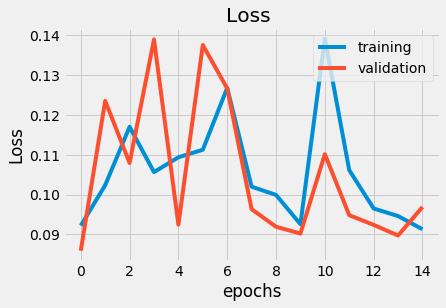

In [0]:
import matplotlib.pyplot as plt
loss=auto_history.history['loss']
plt.style.use("fivethirtyeight")
plt.plot(auto_history.history['loss'])
plt.plot(auto_history.history['val_loss'])
plt.title('Loss ')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='best')
plt.show()

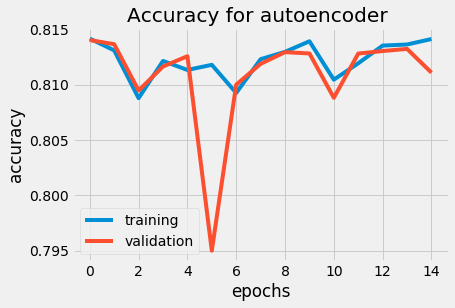

In [0]:
import matplotlib.pyplot as plt
import json
plt.style.use("fivethirtyeight")
plt.plot(auto_history.history['acc'])
plt.plot(auto_history.history['val_acc'])
plt.title('Accuracy for autoencoder ')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='best')
plt.show()

autoencoder.save_weights('autoencoder.h5')
model_json = autoencoder.to_json()
with open("autoencoder.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
# using differentially private autoencoder.
def run_model(private=False,noise=0):
  autoencoder=build_model()
  if private:
    #model should be private
    print('Creating private optimizer')
    microbatches=1
    l2_norm_clip=1.5
    learning_rate=0.001
    optimizer = DPGradientDescentGaussianOptimizer(
                l2_norm_clip=l2_norm_clip,
                noise_multiplier=noise,
                num_microbatches=microbatches,
                learning_rate=learning_rate)
    
    
    autoencoder.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
  return autoencoder
    

In [0]:
autoencoder_dp=run_model(private=True,noise=1.3)
auto_history_dp=autoencoder_dp.fit(train_data,train_data,batch_size=250,epochs=15,validation_data=(test_data,test_data),verbose=1)



Creating private optimizer
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.3875 - acc: 0.8088 - val_loss: 0.2878 - val_acc: 0.8072
Epoch 2/15
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.2719 - acc: 0.8086 - val_loss: 0.2602 - val_acc: 0.8067
Epoch 3/15
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.2522 - acc: 0.8052 - val_loss: 0.2388 - val_acc: 0.8006
Epoch 4/15
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.2356 - acc: 0.7959 - val_loss: 0.2329 - val_acc: 0.7899
Epoch 5/15
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.2295 - acc: 0.7970 - val_loss: 0.2293 - val_acc: 0.7992
Epoch 6/15
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.2249 - acc: 0.7974 - val_loss: 0.2198 - val_acc: 0.8012
Epoch 7/15
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.2263 -

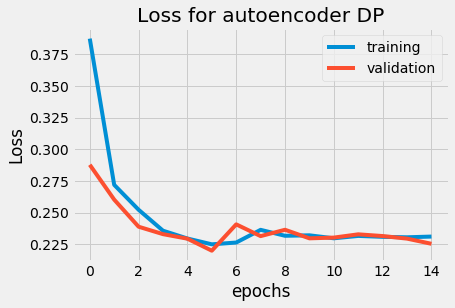

In [0]:
import matplotlib.pyplot as plt
loss=auto_history_dp.history['loss']
plt.style.use("fivethirtyeight")
plt.plot(auto_history_dp.history['loss'])
plt.plot(auto_history_dp.history['val_loss'])
plt.title('Loss for autoencoder DP')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='best')
plt.show()

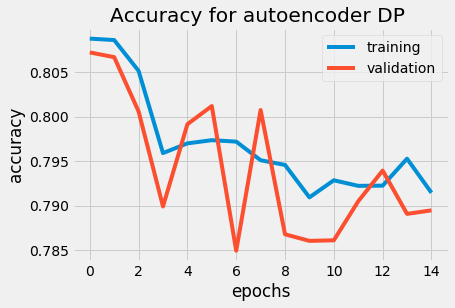

In [0]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(auto_history_dp.history['acc'])
plt.plot(auto_history_dp.history['val_acc'])
plt.title('Accuracy for autoencoder DP ')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='best')
plt.show()

autoencoder_dp.save_weights('autoencoder_dp.h5')
model_json = autoencoder_dp.to_json()
with open("autoencoder_dp_json.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
def encoder_image():
  encoder=tf.keras.models.Sequential()
  encoder.add(tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
  encoder.add(tf.keras.layers.MaxPool2D((2,2),padding='same'))
  encoder.add(tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'))
  encoder.add(tf.keras.layers.MaxPool2D((2,2),padding='same'))
  encoder.add(tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'))
  
  encoder.add(tf.keras.layers.Flatten(trainable=True))
  encoder.add(tf.keras.layers.Dense(32, activation='relu',trainable=True))
  encoder.add(tf.keras.layers.Dense(10, activation='softmax',trainable=True))
  return encoder

final_model=encoder_image()
final_model.summary()
final_model.layers

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)              

In [0]:
for w1,w2 in zip(final_model.layers[:5],autoencoder.layers[0:5]):
    w1.set_weights(w2.get_weights())

#check if weights are same
print(final_model.get_weights()[0][1])
print(autoencoder.get_weights()[0][1])


#now making first 5 layers untrainable

for layer in final_model.layers[0:5]:
    layer.trainable = False

for l in final_model.layers:
    print(l.name, l.trainable)

[[[-0.0160669   0.02172154 -0.01101029  0.10232744 -0.05306724
    0.05945533 -0.09662925 -0.10090534  0.00884497  0.07773782
    0.0772851   0.17647517 -0.13162507 -0.06395884  0.00374468
   -0.04381467]]

 [[ 0.01875766 -0.01453477  0.1235598  -0.13125412 -0.00878669
    0.04030135 -0.19756198 -0.16165897  0.12263848 -0.11716115
    0.0460638   0.1336271   0.206593    0.1384879   0.0031865
    0.09418298]]

 [[-0.01127579  0.19329534  0.13425545 -0.0178904  -0.01863612
    0.05930461 -0.3773375  -0.00952079  0.02198282  0.05643311
    0.08885223 -0.15520991  0.11429475  0.07618798 -0.02414254
    0.02717003]]]
[[[-0.0160669   0.02172154 -0.01101029  0.10232744 -0.05306724
    0.05945533 -0.09662925 -0.10090534  0.00884497  0.07773782
    0.0772851   0.17647517 -0.13162507 -0.06395884  0.00374468
   -0.04381467]]

 [[ 0.01875766 -0.01453477  0.1235598  -0.13125412 -0.00878669
    0.04030135 -0.19756198 -0.16165897  0.12263848 -0.11716115
    0.0460638   0.1336271   0.206593    0.13848

In [0]:
#compiling model
final_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

autoencoder_classification = final_model.fit(train_data, train_labels, batch_size=256,epochs=15,verbose=1,validation_data=(test_data, test_labels))


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 12s 193us/sample - loss: 1.2212 - acc: 0.7119 - val_loss: 0.6106 - val_acc: 0.8580
Epoch 2/15
60000/60000 [==============================] - 11s 187us/sample - loss: 0.4998 - acc: 0.8718 - val_loss: 0.3973 - val_acc: 0.8967
Epoch 3/15
60000/60000 [==============================] - 11s 187us/sample - loss: 0.3786 - acc: 0.8948 - val_loss: 0.3280 - val_acc: 0.9094
Epoch 4/15
60000/60000 [==============================] - 11s 187us/sample - loss: 0.3281 - acc: 0.9059 - val_loss: 0.2947 - val_acc: 0.9180
Epoch 5/15
60000/60000 [==============================] - 11s 187us/sample - loss: 0.2988 - acc: 0.9133 - val_loss: 0.2727 - val_acc: 0.9214
Epoch 6/15
60000/60000 [==============================] - 11s 188us/sample - loss: 0.2790 - acc: 0.9185 - val_loss: 0.2579 - val_acc: 0.9270
Epoch 7/15
60000/60000 [==============================] - 11s 187us/sample - loss: 0.2637 - acc: 0.9225 

DP-SGD with sampling rate = 0.427% and noise_multiplier = 1.3 iterated over 3516 steps satisfies differential privacy with eps = 1.19 and delta = 1e-05.
The optimal RDP order is 17.0.
10000/10000 [==============================] - 2s 158us/sample - loss: 0.2013 - acc: 0.9418


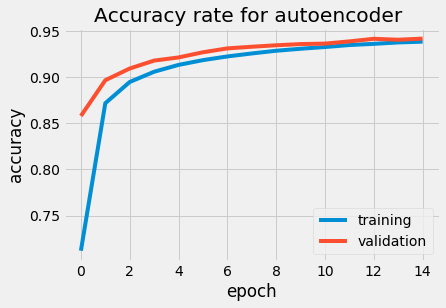

model accuracy :  94.17999982833862


In [0]:
import matplotlib.pyplot as plt
loss_val,metric_acc=final_model.evaluate(test_data,test_labels,batch_size=256,verbose=True)

plt.style.use("fivethirtyeight")
plt.plot(autoencoder_classification.history['acc'])
plt.plot(autoencoder_classification.history['val_acc'])
plt.title('Accuracy rate for autoencoder ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
print("model accuracy : ",str(metric_acc*100))

USING DP-Autoencoder for classification

In [0]:
for w1,w2 in zip(final_model.layers[:5],autoencoder_dp.layers[0:5]):
    w1.set_weights(w2.get_weights())

#check if weights are same
print(final_model.get_weights()[0][1])
print(autoencoder_dp.get_weights()[0][1])


#now making first 5 layers untrainable

for layer in final_model.layers[0:5]:
    layer.trainable = False

for l in final_model.layers:
    print(l.name, l.trainable)

[[[-0.04874389 -0.26272932  0.21814907  0.11579289 -0.00089995
   -0.03050737  0.22656485  0.1590264   0.17884026  0.10958254
   -0.04913115 -0.0206055   0.2151262  -0.07617494  0.0334999
    0.25103715]]

 [[-0.3196901   0.08544001 -0.22467677  0.0878478  -0.0600128
   -0.1704314   0.19457966 -0.19949159 -0.09509097 -0.15143374
    0.04073265 -0.21365592 -0.11574424 -0.01464733  0.16472246
   -0.03672496]]

 [[-0.15319546 -0.03665455  0.23679528 -0.1028779  -0.06617251
    0.20667394 -0.05354733 -0.14621022  0.07739064 -0.21530299
   -0.14621414  0.05504806  0.01137792 -0.00711336 -0.03093613
    0.08388362]]]
[[[-0.04874389 -0.26272932  0.21814907  0.11579289 -0.00089995
   -0.03050737  0.22656485  0.1590264   0.17884026  0.10958254
   -0.04913115 -0.0206055   0.2151262  -0.07617494  0.0334999
    0.25103715]]

 [[-0.3196901   0.08544001 -0.22467677  0.0878478  -0.0600128
   -0.1704314   0.19457966 -0.19949159 -0.09509097 -0.15143374
    0.04073265 -0.21365592 -0.11574424 -0.01464733

In [0]:
#compiling model

final_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

autoencoder_dpC = final_model.fit(train_data, train_labels, batch_size=256,epochs=15,verbose=1,validation_data=(test_data, test_labels))


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 12s 194us/sample - loss: 1.6043 - acc: 0.5153 - val_loss: 0.8654 - val_acc: 0.7501
Epoch 2/15
60000/60000 [==============================] - 11s 188us/sample - loss: 0.6878 - acc: 0.8029 - val_loss: 0.5263 - val_acc: 0.8562
Epoch 3/15
60000/60000 [==============================] - 11s 187us/sample - loss: 0.4719 - acc: 0.8678 - val_loss: 0.4007 - val_acc: 0.8916
Epoch 4/15
60000/60000 [==============================] - 11s 188us/sample - loss: 0.3753 - acc: 0.8945 - val_loss: 0.3336 - val_acc: 0.9089
Epoch 5/15
60000/60000 [==============================] - 11s 187us/sample - loss: 0.3211 - acc: 0.9085 - val_loss: 0.2918 - val_acc: 0.9188
Epoch 6/15
60000/60000 [==============================] - 11s 190us/sample - loss: 0.2867 - acc: 0.9159 - val_loss: 0.2632 - val_acc: 0.9251
Epoch 7/15
60000/60000 [==============================] - 11s 187us/sample - loss: 0.2628 - acc: 0.9237 

10000/10000 [==============================] - 2s 161us/sample - loss: 0.1813 - acc: 0.9435


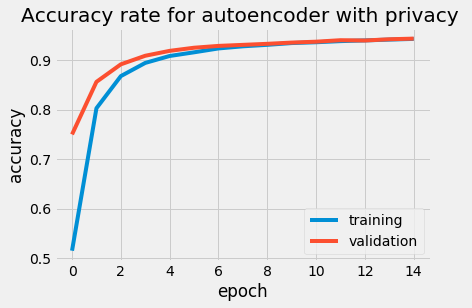

model accuracy :  94.34999823570251


In [0]:
import matplotlib.pyplot as plt
loss_val,metric_acc=final_model.evaluate(test_data,test_labels,batch_size=256,verbose=True)

plt.style.use("fivethirtyeight")
plt.plot(autoencoder_dpC.history['acc'])
plt.plot(autoencoder_dpC.history['val_acc'])
plt.title('Accuracy rate for autoencoder with privacy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
print("model accuracy : ",str(metric_acc*100))

In [0]:
#compiling model

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

optimizer = DPGradientDescentGaussianOptimizer(l2_norm_clip=1.5,
                                            noise_multiplier=1.3,
                                            num_microbatches=1,
                                            learning_rate=0.001)

final_model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])

autoencoder_dpC_noise = final_model.fit(train_data, train_labels, batch_size=250,epochs=15,verbose=1,validation_data=(test_data, test_labels))


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 12s 204us/sample - loss: 1.5546 - acc: 0.9419 - val_loss: 1.5604 - val_acc: 0.9353
Epoch 2/15
60000/60000 [==============================] - 12s 192us/sample - loss: 1.5605 - acc: 0.9376 - val_loss: 1.5556 - val_acc: 0.9390
Epoch 3/15
60000/60000 [==============================] - 12s 193us/sample - loss: 1.5592 - acc: 0.9385 - val_loss: 1.5598 - val_acc: 0.9351
Epoch 4/15
60000/60000 [==============================] - 12s 193us/sample - loss: 1.5591 - acc: 0.9367 - val_loss: 1.5562 - val_acc: 0.9353
Epoch 5/15
60000/60000 [==============================] - 12s 193us/sample - loss: 1.5593 - acc: 0.9359 - val_loss: 1.5558 - val_acc: 0.9347
Epoch 6/15
60000/60000 [==============================] - 12s 193us/sample - loss: 1.5576 - acc: 0.9365 - val_loss: 1.5549 - val_acc: 0.9368
Epoch 7/15
60000/60000 [==============================] - 12s 192us/sample - loss: 1.5602 - acc: 0.9346 

10000/10000 [==============================] - 2s 163us/sample - loss: 1.5700 - acc: 0.9236
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.3 iterated over 24000 steps satisfies differential privacy with eps = 3 and delta = 1e-05.
The optimal RDP order is 9.0.


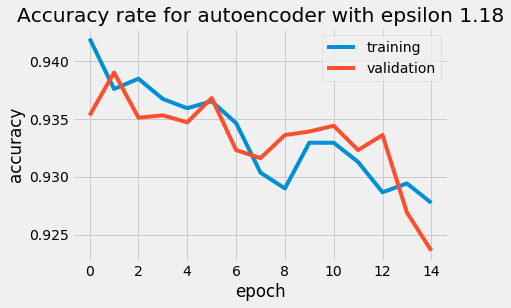

model accuracy :  92.36000180244446


In [0]:
import matplotlib.pyplot as plt
loss_val,metric_acc=final_model.evaluate(test_data,test_labels,batch_size=250,verbose=True)
epsilon=compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=60000, batch_size=250, noise_multiplier=1.3, epochs=100, delta=1e-5)


plt.style.use("fivethirtyeight")
plt.plot(autoencoder_dpC_noise.history['acc'])
plt.plot(autoencoder_dpC_noise.history['val_acc'])
plt.title('Accuracy rate for autoencoder with epsilon 1.18')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
print("model accuracy : ",str(metric_acc*100))

# Checking the accuracy for high noise multiplier of 5.0 for 15 epochs of training on classifier.


In [0]:
autoencoder_dp=run_model(private=True,noise=5.0)
auto_history_dp=autoencoder_dp.fit(train_data,train_data,batch_size=250,epochs=15,validation_data=(test_data,test_data),verbose=1)



Creating private optimizer
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.4211 - acc: 0.7944 - val_loss: 0.5968 - val_acc: 0.5542
Epoch 2/15
60000/60000 [==============================] - 60s 995us/sample - loss: 1.2319 - acc: 0.6259 - val_loss: 1.3445 - val_acc: 0.7252
Epoch 3/15
60000/60000 [==============================] - 60s 1ms/sample - loss: 0.9709 - acc: 0.7343 - val_loss: 0.9248 - val_acc: 0.6698
Epoch 4/15
60000/60000 [==============================] - 60s 998us/sample - loss: 1.2192 - acc: 0.7161 - val_loss: 1.4868 - val_acc: 0.7970
Epoch 5/15
60000/60000 [==============================] - 60s 999us/sample - loss: 1.6059 - acc: 0.7732 - val_loss: 1.7286 - val_acc: 0.7900
Epoch 6/15
60000/60000 [==============================] - 60s 1ms/sample - loss: 1.9029 - acc: 0.7780 - val_loss: 2.2703 - val_acc: 0.7804
Epoch 7/15
60000/60000 [==============================] - 60s 999us/sample - loss: 

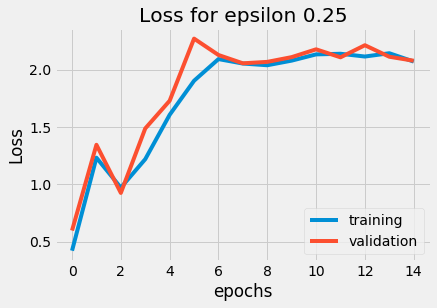

In [0]:
import matplotlib.pyplot as plt
loss=auto_history_dp.history['loss']
plt.style.use("fivethirtyeight")
plt.plot(auto_history_dp.history['loss'])
plt.plot(auto_history_dp.history['val_loss'])
plt.title('Loss for epsilon 0.25')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='best')
plt.show()

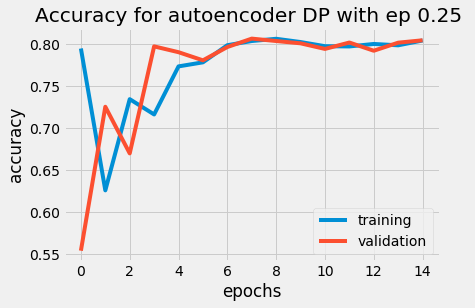

In [0]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(auto_history_dp.history['acc'])
plt.plot(auto_history_dp.history['val_acc'])
plt.title('Accuracy for autoencoder DP with ep 0.25 ')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [0]:
for w1,w2 in zip(final_model.layers[:5],autoencoder_dp.layers[0:5]):
    w1.set_weights(w2.get_weights())


for layer in final_model.layers[0:5]:
    layer.trainable = False

optimizer = DPGradientDescentGaussianOptimizer(l2_norm_clip=1.5,
                                            noise_multiplier=5.0,
                                            num_microbatches=250,
                                            learning_rate=0.001)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

final_model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])

autoencoder_dpC_noise = final_model.fit(train_data, train_labels, batch_size=250,epochs=15,verbose=1,validation_data=(test_data, test_labels))


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 39s 652us/sample - loss: 2.3567 - acc: 0.1030 - val_loss: 2.3577 - val_acc: 0.1024
Epoch 2/15
60000/60000 [==============================] - 38s 633us/sample - loss: 2.3566 - acc: 0.1031 - val_loss: 2.3576 - val_acc: 0.1024
Epoch 3/15
60000/60000 [==============================] - 38s 634us/sample - loss: 2.3565 - acc: 0.1032 - val_loss: 2.3575 - val_acc: 0.1025
Epoch 4/15
60000/60000 [==============================] - 38s 633us/sample - loss: 2.3564 - acc: 0.1034 - val_loss: 2.3573 - val_acc: 0.1028
Epoch 5/15
60000/60000 [==============================] - 38s 640us/sample - loss: 2.3562 - acc: 0.1036 - val_loss: 2.3572 - val_acc: 0.1030
Epoch 6/15
60000/60000 [==============================] - 38s 637us/sample - loss: 2.3561 - acc: 0.1037 - val_loss: 2.3571 - val_acc: 0.1030
Epoch 7/15
60000/60000 [==============================] - 38s 635us/sample - loss: 2.3560 - acc: 0.1038 

10000/10000 [==============================] - 2s 158us/sample - loss: 2.3561 - acc: 0.1038
DP-SGD with sampling rate = 0.00167% and noise_multiplier = 5.0 iterated over 900000 steps satisfies differential privacy with eps = 0.0251 and delta = 1e-05.
The optimal RDP order is 512.0.
The privacy estimate is likely to be improved by expanding the set of orders.


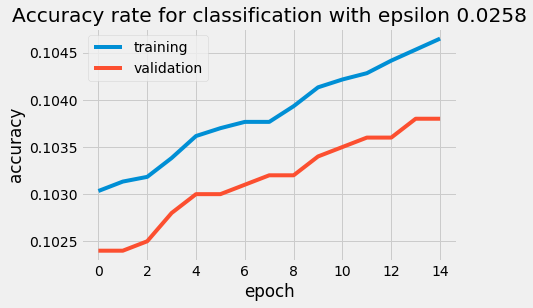

model accuracy :  10.379999876022339


In [0]:
import matplotlib.pyplot as plt
loss_val,metric_acc=final_model.evaluate(test_data,test_labels,batch_size=250,verbose=True)
epsilon=compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=60000, batch_size=1, noise_multiplier=5.0, epochs=15, delta=1e-5)


plt.style.use("fivethirtyeight")
plt.plot(autoencoder_dpC_noise.history['acc'])
plt.plot(autoencoder_dpC_noise.history['val_acc'])
plt.title('Accuracy rate for classification with epsilon 0.0258')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
print("model accuracy : ",str(metric_acc*100))